In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
spikes=np.load('spikes.npy')
cell_identity=np.load('cell_identity.npy')[spikes>0]
spikes=spikes[spikes>0]

In [3]:
start=time.time()
simulation_clock=Clock(dt = 0.01*ms)
defaultclock.dt = 0.01*ms
tau = 10*ms
vr = -70*mV
vt = -60*mV
Vth_i= -50.0*mV
Vr_i= -60.0*mV
eqs = '''
dv/dt = (I_ampa+I_gaba)/Cm : volt
I_ampa=-g_ext_ampa*s_ext*(v-E_ampa) : amp
I_gaba=-g_ext_gaba*s_gaba*(v-E_gaba) : amp
ds_ext/dt=-s_ext/t_ampa : 1
ds_gaba/dt = -s_gaba/t_gaba : 1
'''
eqs_i='''
dv/dt = (I_ampa+I_gaba)/Cm : volt
I_ampa=-g_ext_i*s_ext*(v-E_ampa) : amp
I_gaba=-g_gaba*s_gaba*(v-E_gaba) : amp
ds_ext/dt=-s_ext/t_ampa : 1
ds_gaba/dt = -s_gaba/t_gaba : 1
'''
eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''
tau_stdp = 20*ms    # STDP time constant
t_ampa=2*ms
t_gaba= 10.0*ms
Cm= 0.5*nF
E_ampa=0.0*mV
E_gaba = -70.0*mV
g_ext_ampa=3.1*nS
g_gaba=1.024*nS
g_ext_gaba=1.34765625*nS
g_ext_i= 2.38*nS 
neuron = NeuronGroup(100, eqs, threshold='v>vt', reset='v=vr')
neuron_inh=NeuronGroup(50,eqs_i,threshold='v>Vth_i', reset='v=Vr_i')
neuron.v = E_ampa
neuron_inh.v=E_gaba
neuron.s_ext = 0
neuron_inh.s_ext = 0
neuron_inh.s_gaba = 0
alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
eta = 1e-2 
spikes_gen=SpikeGeneratorGroup(1000,list(cell_identity),spikes*ms)
w = 1
S1 = Synapses(spikes_gen, neuron, on_pre='s_ext += 0.25')
S1.connect(p=0.1)
S2 = Synapses(neuron, neuron, on_pre='s_ext += 0.25')
S2.connect(p=0.5)
S3 = Synapses(neuron_inh, neuron, model=eqs_stdp_inhib,
                  on_pre='''Apre += 1.
                         w = clip(w+(Apost-alpha)*eta, 0, gmax)
                         s_gaba += w''',
                  on_post='''Apost += 1.
                          w = clip(w+Apre*eta, 0, gmax)
                       ''')
S3.connect(p=0.5)
#S4 = Synapses(neuron_inh, neuron_inh, on_pre='s_gaba += 1.0')
#S4.connect(p=0.25)
S5 = Synapses(spikes_gen, neuron_inh, on_pre='s_ext += 0.25')
S5.connect(p=0.1)
S6 = Synapses(neuron, neuron_inh, on_pre='s_ext += 0.25')
S6.connect(p=0.5)
# Record the spikes
Mgp = SpikeMonitor(neuron)
Minput = SpikeMonitor(spikes_gen)
pop=PopulationRateMonitor(spikes_gen)
I_ampa_lst=[]
I_gaba_lst=[]
@network_operation(simulation_clock,when='start')
def update_nmda(simulation_clock):
    I_ampa=np.sum(neuron.I_ampa[:])
    I_gaba=np.sum(neuron.I_gaba[:])
    I_ampa_lst.append(I_ampa)
    I_gaba_lst.append(I_gaba)
duration=10000*ms
run(duration)
end=time.time()
print(end-start)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.03s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
WARNING    "w" is an internal variable of group "synapses_2", but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


7234.245915174484


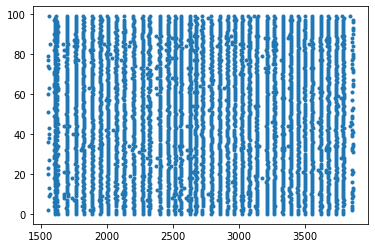

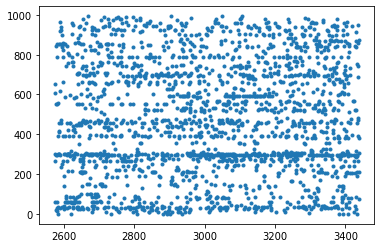

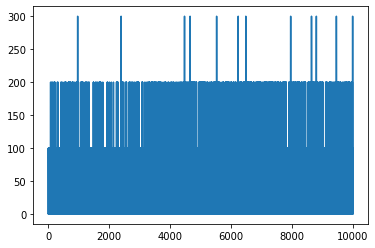

In [4]:
plot(Mgp.t[4000:8000]/ms, Mgp.i[4000:8000], '.')
plt.show()
plot(Minput.t[4000:6000]/ms,Minput.i[4000:6000],'.')
plt.show()
plot(pop.t/ms, pop.rate/Hz)

Starting simulation at t=0. s for a duration of 20. s
1.03747 s (5%) simulated in 10s, estimated 3m 3s remaining.
2.08688 s (10%) simulated in 20s, estimated 2m 52s remaining.
2.74325 s (13%) simulated in 30s, estimated 3m 9s remaining.
3.58123 s (17%) simulated in 40s, estimated 3m 3s remaining.
4.64325 s (23%) simulated in 50s, estimated 2m 45s remaining.
5.68379 s (28%) simulated in 1m 0s, estimated 2m 31s remaining.
6.57825 s (32%) simulated in 1m 10s, estimated 2m 23s remaining.
7.33813 s (36%) simulated in 1m 20s, estimated 2m 18s remaining.
8.1505 s (40%) simulated in 1m 30s, estimated 2m 11s remaining.
8.84227 s (44%) simulated in 1m 40s, estimated 2m 6s remaining.
9.54597 s (47%) simulated in 1m 50s, estimated 2m 0s remaining.
10.30076 s (51%) simulated in 2m 0s, estimated 1m 53s remaining.
11.05191 s (55%) simulated in 2m 10s, estimated 1m 45s remaining.
11.76738 s (58%) simulated in 2m 20s, estimated 1m 38s remaining.
12.41349 s (62%) simulated in 2m 30s, estimated 1m 32s re

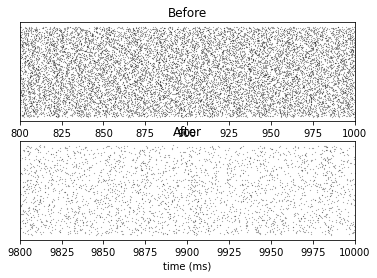

In [5]:
b

In [6]:
np.save('Mgpt_AMPA_GABA_rec_NP.npy',t)
np.save('Mgpi_AMPA_GABA_rec_NP.npy',i)

In [7]:
spikes=np.load('M_t.npy')*1000
cell_identity=np.load('M_i.npy')

Starting simulation at t=0. s for a duration of 20. s
0.68375 s (3%) simulated in 10s, estimated 4m 43s remaining.
1.48261 s (7%) simulated in 20s, estimated 4m 10s remaining.
2.35897 s (11%) simulated in 30s, estimated 3m 44s remaining.
3.1786 s (15%) simulated in 40s, estimated 3m 32s remaining.
4.04876 s (20%) simulated in 50s, estimated 3m 17s remaining.
4.90069 s (24%) simulated in 1m 0s, estimated 3m 5s remaining.
5.69595 s (28%) simulated in 1m 10s, estimated 2m 56s remaining.
6.51554 s (32%) simulated in 1m 20s, estimated 2m 46s remaining.
7.44648 s (37%) simulated in 1m 30s, estimated 2m 32s remaining.
8.39769 s (41%) simulated in 1m 40s, estimated 2m 18s remaining.
9.30556 s (46%) simulated in 1m 50s, estimated 2m 6s remaining.
10.24642 s (51%) simulated in 2m 0s, estimated 1m 54s remaining.
11.14858 s (55%) simulated in 2m 10s, estimated 1m 43s remaining.
12.12382 s (60%) simulated in 2m 20s, estimated 1m 31s remaining.
13.1246 s (65%) simulated in 2m 30s, estimated 1m 19s r

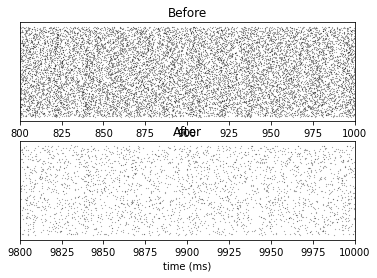

In [8]:
from brian2 import *

# ###########################################
# Defining network model parameters
# ###########################################

defaultclock.dt = 0.01*ms

NE = 1000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells

tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections

tau_stdp = 20*ms    # STDP time constant

simtime = 10*second # Simulation time

# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current

eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''

# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
Pe = neurons[:NE]
Pi = neurons[NE:]

spikes_gen=SpikeGeneratorGroup(1000,list(cell_identity),spikes*ms)

# ###########################################
# Connecting the network
# ###########################################

con_e = Synapses(Pe, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(p=epsilon)
con_ii = Synapses(Pi, Pi, on_pre='g_gaba += 3*nS')
con_ii.connect(p=epsilon)
con_ext= Synapses(spikes_gen,neurons,on_pre='g_ampa += 0.3*nS')
con_ext.connect(p=0.1)

# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''
alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight

con_ie = Synapses(Pi, Pe, model=eqs_stdp_inhib,
                  on_pre='''Apre += 1.
                         w = clip(w+(Apost-alpha)*eta, 0, gmax)
                         g_gaba += w*nS''',
                  on_post='''Apost += 1.
                          w = clip(w+Apre*eta, 0, gmax)
                       ''')
con_ie.connect(p=epsilon)
con_ie.w = 1e-10

# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(Pe)

# ###########################################
# Run without plasticity
# ###########################################
#eta = 0          # Learning rate
#run(1*second)

# ###########################################
# Run with plasticity
# ###########################################
eta = 1e-2          # Learning rate
run(20000*ms, report='text')

# ###########################################
# Make plots
# ###########################################

i, t = sm.it
subplot(211)
plot(t/ms, i, 'k.', ms=0.25)
title("Before")
xlabel("")
yticks([])
xlim(0.8*1e3, 1*1e3)
subplot(212)
plot(t/ms, i, 'k.', ms=0.25)
xlabel("time (ms)")
yticks([])
title("After")
xlim((simtime-0.2*second)/ms, simtime/ms)
show()

In [9]:
np.save('Mgpt_AMPA_GABA_rec_poisson.npy',t)
np.save('Mgpi_AMPA_GABA_rec_poisson.npy',i)